<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

##Drug Overdose Deaths
###Feature Importance

* Akshat Bhardwaj <akshatb4@illinois.edu>,
[LinkedIn](https://www.linkedin.com/in/akshat-bhardwaj/)
* Catherine Li <sl182@illinois.edu>,
[LinkedIn](https://www.linkedin.com/in/catherine-li-482797252/)
* Hélène Rondey <hrondey2@illinois.edu>,
[LinkedIn](https://www.linkedin.com/in/h%C3%A9l%C3%A8ne-r-98401a1b7?lipi=urn%3Ali%3Apage%3Ad_flagship3_profile_view_base_contact_details%3BzsAqgF02Qd2grkWQ0eXwXg%3D%3D)
* Yang-Hsuan Huang <yhh4@illinois.edu>,
[LinkedIn](https://www.linkedin.com/in/yang-hsuan-huang-904148281?lipi=urn%3Ali%3Apage%3Ad_flagship3_profile_view_base_contact_details%3BCxCLmEzYQqKYAfU3aoIUug%3D%3D)


## Packages

In [5]:
!pip install https://github.com/ceshine/shap/archive/master.zip
!pip install skorch

  Using cached https://github.com/ceshine/shap/archive/master.zip
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 4.7 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import shap
import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNet

from matplotlib import pyplot as plt
import pickle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/MyDrive/Deep_Dive_Group_1
#%cd /content/drive/Shareddrives/Deep_Dive_Group_1

/content/drive/MyDrive/Deep_Dive_Group_1


## Importing the model

In [9]:

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(69, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.layers(x)

def create_net(optimizer_name, epochs=10):
    if optimizer_name == 'adam':
      net = NeuralNet(
              FeedForwardNN(),
             criterion=nn.MSELoss(),
          # Shuffle training data on each epoch
             iterator_train__shuffle=True,
              optimizer= torch.optim.Adam,
              verbose=True,
              max_epochs= epochs,
              train_split=None#,
              #callbacks=[EarlyStopping(patience=5)]
             )

    elif optimizer_name == 'rms':
      net = NeuralNet(
              FeedForwardNN(),
             criterion=nn.MSELoss(),
          # Shuffle training data on each epoch
             iterator_train__shuffle=True,
              optimizer= torch.optim.RMSprop,
              verbose=True,
              max_epochs= epochs,
              train_split=None#,
              #callbacks=[EarlyStopping(patience=5)]
             )
    elif optimizer_name == 'sgd':
      net = NeuralNet(
              FeedForwardNN(),
             criterion=nn.MSELoss(),
          # Shuffle training data on each epoch
             iterator_train__shuffle=True,
              optimizer= torch.optim.SGD,
              verbose=True,
              max_epochs= epochs,
              train_split=None#,
             # callbacks=[EarlyStopping(patience=5)]
             )
    return net


In [53]:
#Loading the weights and retrieving the model (FeedForwardNN object)
loaded_net = create_net(optimizer_name="adam")
loaded_net.initialize()
loaded_net.load_params(f_params='adam_state_dict.pkl')
adam_state_dict = loaded_net.module_.state_dict()

In [54]:
model = FeedForwardNN()
model.load_state_dict(adam_state_dict)
model.eval()

FeedForwardNN(
  (layers): Sequential(
    (0): Linear(in_features=69, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
  )
)

##Importing the data

In [12]:
df_preprocessed = pd.read_csv("data_preprocessed.csv", thousands=',').astype("float32")


In [15]:
label = ['Predicted_value']
feature = ['Year', 'Percent_pending_investigation',
      'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
      'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI',
      'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY',
      'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO',
      'State_MS', 'State_MT', 'State_NC', 'State_NH', 'State_NJ', 'State_NM',
      'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_RI',
      'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
      'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'State_YC',
      'Month_April', 'Month_August', 'Month_December', 'Month_February',
      'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
      'Month_November', 'Month_October', 'Month_September',
      'Indicator_Cocaine (T40.5)',
      'Indicator_Heroin (T40.1)',
      'Indicator_Methadone (T40.3)',
      'Indicator_Natural & semi-synthetic opioids (T40.2)',
      'Indicator_Opioids (T40.0-T40.4,T40.6)',
      'Indicator_Psychostimulants with abuse potential (T43.6)',
      'Indicator_Synthetic opioids, excl. methadone (T40.4)']

X = df_preprocessed[feature]
Y = df_preprocessed[label]


In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
# Creating training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=42, test_size=0.15)

# Converting the data in PyTorch tensors
X_train, y_train = X_train.values, y_train.values
X_test, y_test = X_test.values, y_test.values
y_train, y_test, = y_train.reshape(-1), y_test.reshape(-1)

# SHAP Values

The code is inspired by : https://www.kaggle.com/code/ceshine/feature-importance-from-a-pytorch-model

For the sake of computation time, we use the Testing set to compute the SHAP values.

In [55]:
e = shap.DeepExplainer(
        model,
        torch.from_numpy(X_test))

In [56]:
shap_values = e.shap_values(
    torch.from_numpy(X_test)
)

In [64]:
df = pd.DataFrame({
    "sum_shap" : np.sum(shap_values, axis=0),
    "sum_abs_shap" : np.sum(np.abs(shap_values), axis=0),
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0),
    "name": feature
})
df.sort_values("mean_abs_shap", ascending=False).head(15)

,sum_shap,sum_abs_shap,mean_abs_shap,stdev_abs_shap,name
66,1.561362e-06,47.404377,0.012618,0.016078,"Indicator_Opioids (T40.0-T40.4,T40.6)"
0,8.942761e-07,43.710667,0.011634,0.016610,Year
64,1.243810e-06,39.798446,0.010593,0.014240,Indicator_Methadone (T40.3)
65,-6.913626e-08,25.206601,0.006709,0.009777,Indicator_Natural & semi-synthetic opioids (T4...
63,-2.141894e-07,24.156765,0.006430,0.009184,Indicator_Heroin (T40.1)
68,-1.438394e-06,23.412079,0.006232,0.010408,"Indicator_Synthetic opioids, excl. methadone (..."
67,6.084929e-08,20.859645,0.005552,0.009719,Indicator_Psychostimulants with abuse potentia...
62,3.688892e-07,19.591140,0.005215,0.006905,Indicator_Cocaine (T40.5)
6,-1.230510e-07,18.199469,0.004844,0.024232,State_CA
34,9.049545e-07,15.449325,0.004112,0.014785,State_OH


From this table, it seems that the (encoded) features with the highest absolute SHAP impacts are the Indicators for Opioids (by far), Methadone, Synthetic opiods and the Year. In other words, these features are the most determining in the predictions.

/usr/local/lib/python3.10/dist-packages/shap/plots/summary.py:188: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  pl.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777", vmin=vmin,


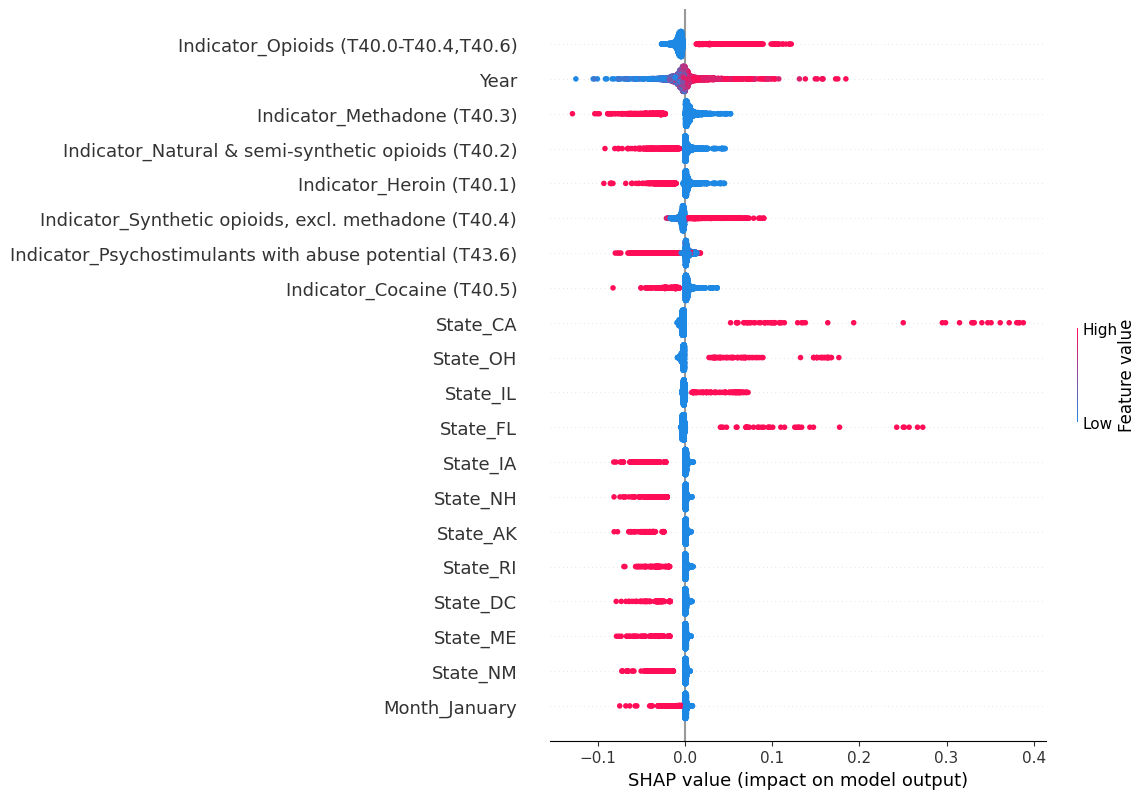

In [59]:
shap.summary_plot(shap_values, features=X_test, feature_names=feature)

From this plot, it seems that the indicators for Opiods and Synthetic Opioids mostly have a positive effect on the prediction (positive and high shap values when the feature has a high value), as well as the indicators for the states of California, Ohio, Florida and Illinois. Plus, Methadone, Natyral & Semi-synthetic Opioids, Psychostimulants and Cocaine seem to be responsible for smaller predictions (negative SHAP values). All of these remarks are similar to our observations from the Data Exploration, so it shows that the model was capable of capturing trends among the features.

In [60]:
States = [      'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
      'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI',
      'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY',
      'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO',
      'State_MS', 'State_MT', 'State_NC', 'State_NH', 'State_NJ', 'State_NM',
      'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_RI',
      'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
      'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'State_YC',
      ]

Date = ['Month_April', 'Month_August', 'Month_December', 'Month_February',
      'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
      'Month_November', 'Month_October', 'Month_September', "Year"
      ]

Drugtypes = ['Indicator_Cocaine (T40.5)',
      'Indicator_Heroin (T40.1)',
      'Indicator_Methadone (T40.3)',
      'Indicator_Natural & semi-synthetic opioids (T40.2)',
      'Indicator_Opioids (T40.0-T40.4,T40.6)',
      'Indicator_Psychostimulants with abuse potential (T43.6)',
      'Indicator_Synthetic opioids, excl. methadone (T40.4)']

df["Variable"]= df.name.apply(lambda x: "State" if x in States else ("Date" if x in Date else ("Drugtype" if x in Drugtypes else x)))

df_shap_sum = df.groupby("Variable").sum()

<ipython-input-60-357937aa4fff>:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_shap_sum = df.groupby("Variable").sum()


In [62]:
df_shap_sum

,sum_shap,sum_abs_shap,mean_abs_shap,stdev_abs_shap
Variable,,,,
Date,1.551274e-06,98.405564,0.026193,0.046844
Drugtype,1.513191e-06,200.429053,0.053348,0.076312
Percent_pending_investigation,-6.992617e-08,2.098598,0.000559,0.001424
State,2.348202e-06,237.457678,0.063204,0.244325


Looking at the global (absolute) effects of each variable, it seems that the State has the biggest impact in the prediction, followed by the Drug Type, and then the date. Percent Pending Investigation (@Benjamin) looks insignificant in terms of SHAP effect.